In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

%matplotlib ipympl

In [7]:
class MeasurementNoise:
    def __init__(self, sample_rate):
        self._sample_rate = sample_rate

    def frequency_sensitivity(self, times, data):
        freqs = np.fft.rfftfreq(len(data), times[1] - times[0])
        amplitudes = np.abs(np.fft.rfft(data)) / self._sample_rate / np.sqrt(max(times))
        return (freqs, amplitudes)

    def single_shot_measurement_noise(self, freqs, sensitivity_amplitudes, intensity_noise_func):
        noises = np.array([noise(freq) for freq in freqs])
        return np.sqrt(np.sum((noises * sensitivity_amplitudes) ** 2 * (freqs[1] - freqs[0])))

In [8]:
class ProbeGroups(MeasurementNoise):
    def __init__(self, probe_times, wait_times, weights, repeats, sample_rate=25e6):
        super().__init__(sample_rate)
        self._probe_times = probe_times
        self._wait_times = wait_times
        self._weights = weights
        self._repeats = repeats

    def time_domain_data(self):
        data = np.array([])
        for kk in range(len(self._probe_times)):
            probe_time = self._probe_times[kk]
            wait_time = self._wait_times[kk]
            weight = self._weights[kk]
            probe_ones = np.ones(int(probe_time * self._sample_rate)) / np.sqrt(probe_time * self._repeats) * weight
            wait_zeros = np.zeros(int(wait_time * self._sample_rate))
            data = np.append(np.append(data, probe_ones), wait_zeros)
        data = np.tile(data, self._repeats)
        times = np.arange(len(data)) / self._sample_rate
        return (times, data)

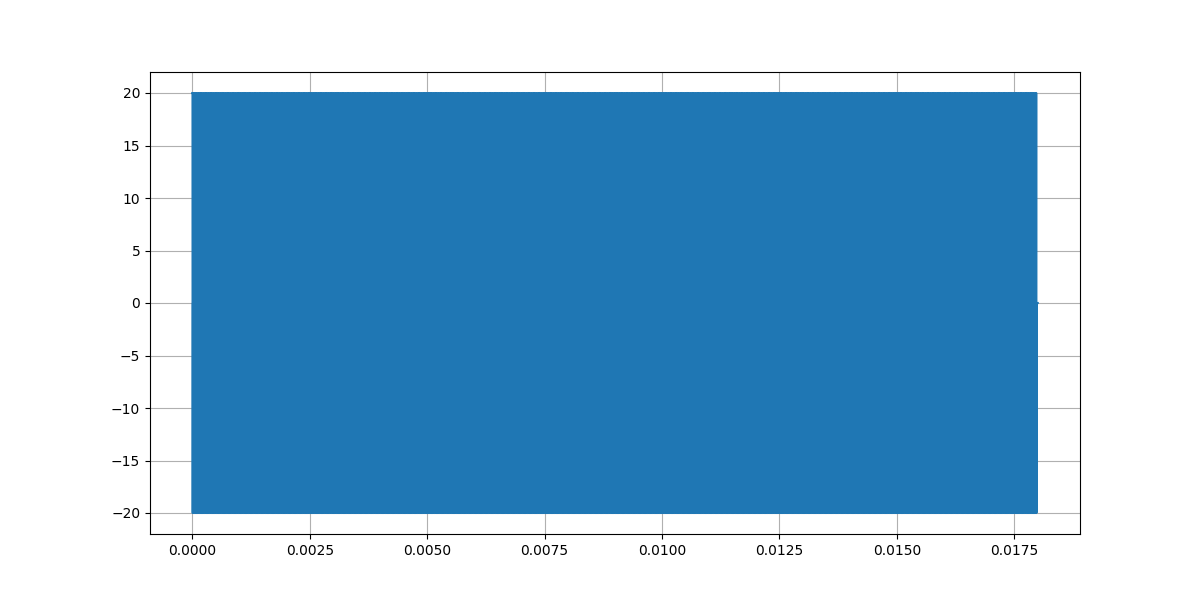

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))
pg1 = ProbeGroups([5e-6, 5e-6], [1e-6, 25e-6], [1, -1], 1)
pg = ProbeGroups([5e-6, 5e-6], [1e-6, 25e-6], [1, -1], 500)
ax.plot(*pg.time_domain_data())
ax.grid()
plt.show()

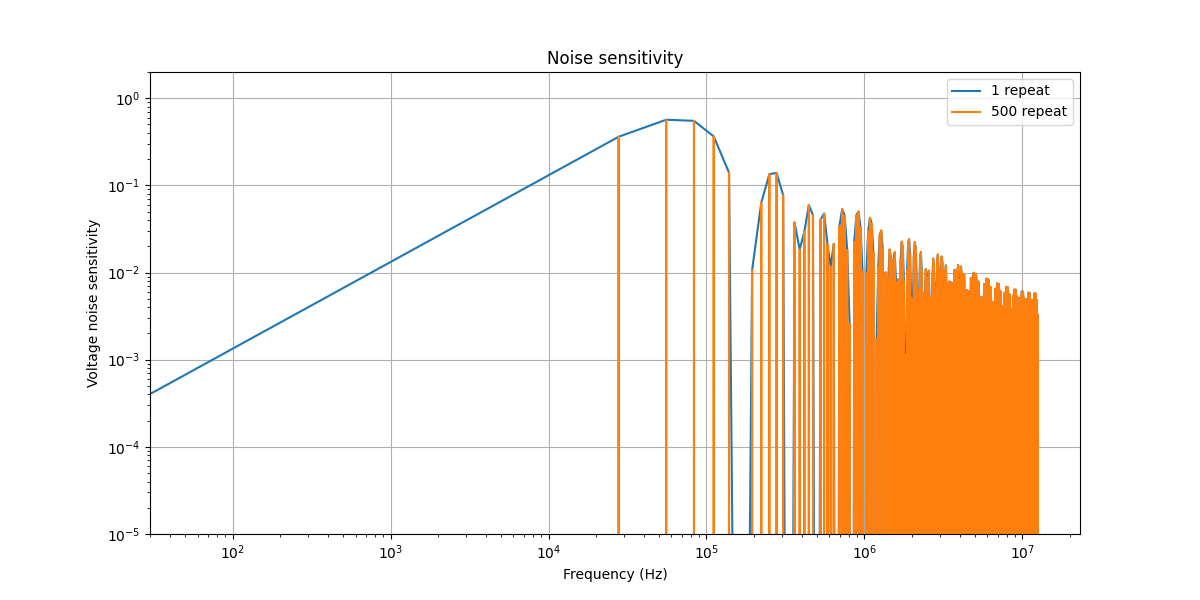

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))
freqs, amplitudes = pg1.frequency_sensitivity(*pg1.time_domain_data())
ax.plot(freqs, amplitudes, label="1 repeat")
freqs, amplitudes = pg.frequency_sensitivity(*pg.time_domain_data())
ax.plot(freqs, amplitudes, label="500 repeat")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Voltage noise sensitivity")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Noise sensitivity")
ax.set_ylim(1e-5, 2)
ax.grid()
ax.legend()
plt.show()

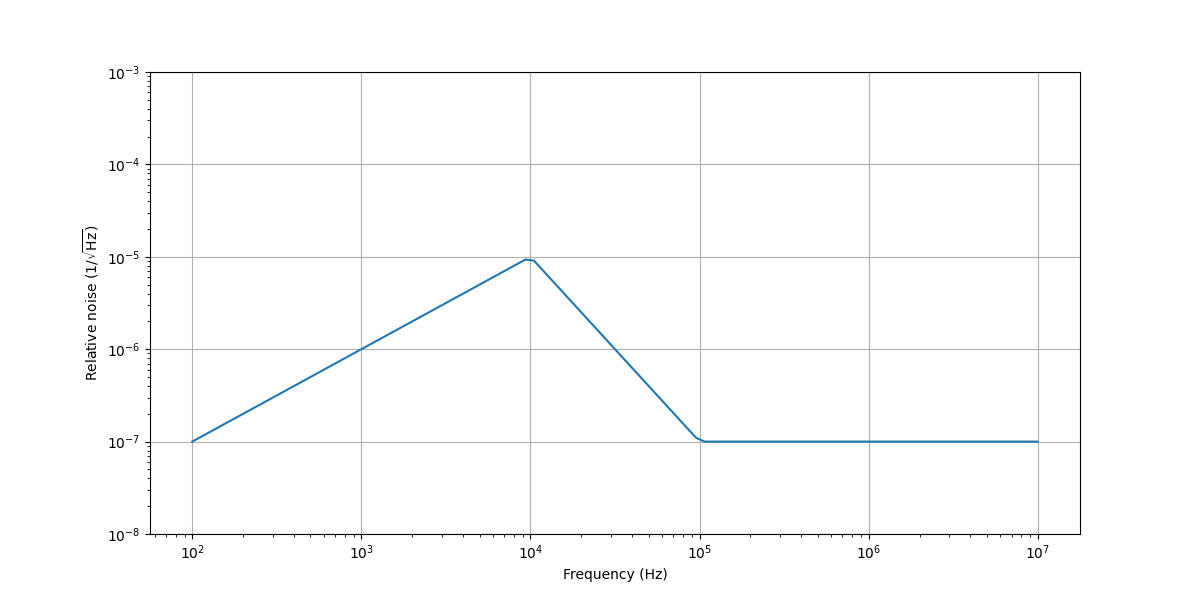

In [58]:
def noise(f):
    if f > 1e2 and f < 1e4:
        return f / 1e2 * 1e-7
    elif f < 1e5 and f >= 1e4:
        return (1e5 / f) ** 2 * 1e-7
    else:
        return 1e-7

fig, ax = plt.subplots(figsize=(12, 6))
x = np.logspace(2, 7, 100)
noises = [noise(x1) for x1 in x]
ax.plot(x, noises)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Relative noise ($1/\\sqrt{\\mathrm{Hz}}$)")
ax.set_ylim(1e-8, 1e-3)
ax.grid()
plt.show()

In [60]:
print(pg1.single_shot_measurement_noise(*pg1.frequency_sensitivity(*pg1.time_domain_data()), noise))
print(pg.single_shot_measurement_noise(*pg.frequency_sensitivity(*pg.time_domain_data()), noise))

8.524105526498132e-05
3.8099816945832265e-06


In [223]:
class SingleProbe:
    def __init__(self, probe_time, wait_time, sample_rate=25e6, total_time=0.001, frequency=0, repeats=32):
        self._probe_time = probe_time
        self._wait_time = wait_time
        self._total_time = total_time
        self._sample_rate = sample_rate
        self._frequency = frequency
        self._repeats = repeats

    def time_domain_data(self):
        if self._frequency > 0:
            times = np.arange(int(self._probe_time * self._sample_rate)) / self._sample_rate
            probe_ones = np.sin(2 * np.pi * self._frequency * times) * np.sqrt(2) / np.sqrt(self._probe_time * self._repeats)
        else:
            probe_ones = np.ones(int(self._probe_time * self._sample_rate)) / np.sqrt(self._probe_time * self._repeats)
        wait_zeros = np.zeros(int(self._wait_time * self._sample_rate))
        probe_minus_ones = -probe_ones
        total_zeros = np.zeros(int((self._total_time - self._wait_time - self._probe_time * 2) * self._sample_rate))
        data = np.repeat([np.append(np.append(np.append(probe_ones, wait_zeros), probe_minus_ones),wait_zeros)], self._repeats, axis=0).flatten()
        data = np.append(data, total_zeros)
        times = np.arange(len(data)) / self._sample_rate
        return (times, data)

    def frequency_sensitivity(self):
        times, data = self.time_domain_data()
        freqs = np.fft.rfftfreq(len(data), times[1] - times[0])
        amplitudes = np.abs(np.fft.rfft(data)) / self._sample_rate / np.sqrt(max(times))
        return (freqs, amplitudes)

800.7046200656577


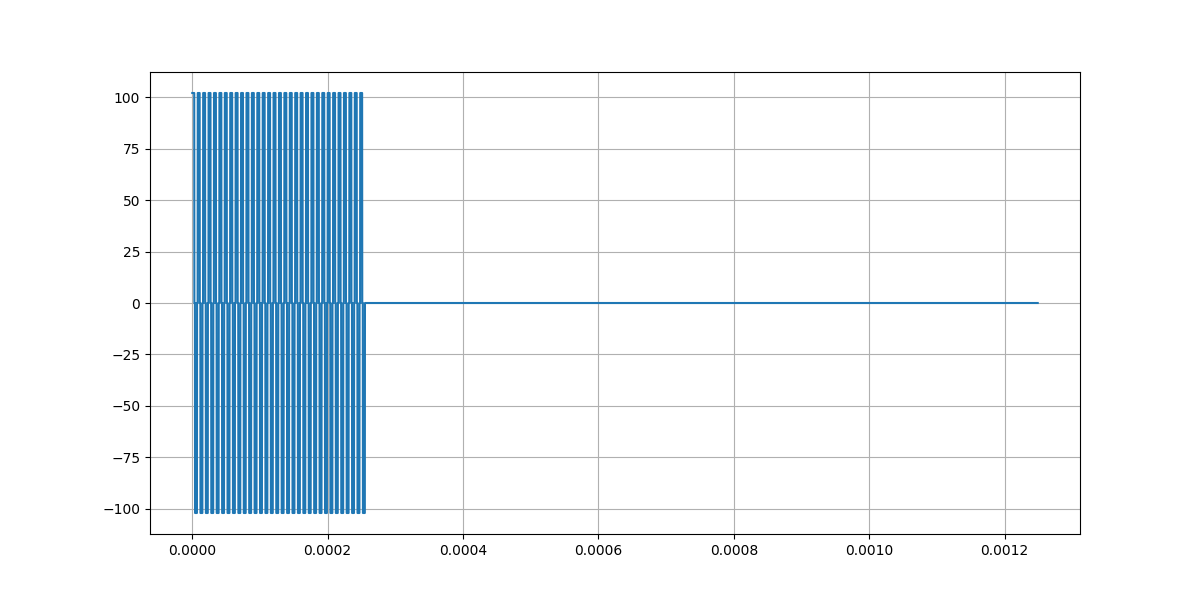

In [230]:
fig, ax = plt.subplots(figsize=(12, 6))
sp = SingleProbe(3e-6, 1e-6, sample_rate=10e6)
print(np.sum(amplitudes**2) * (freqs[1] - freqs[0]))
ax.plot(*sp.time_domain_data())
ax.grid()
plt.show()

800.7046200656577


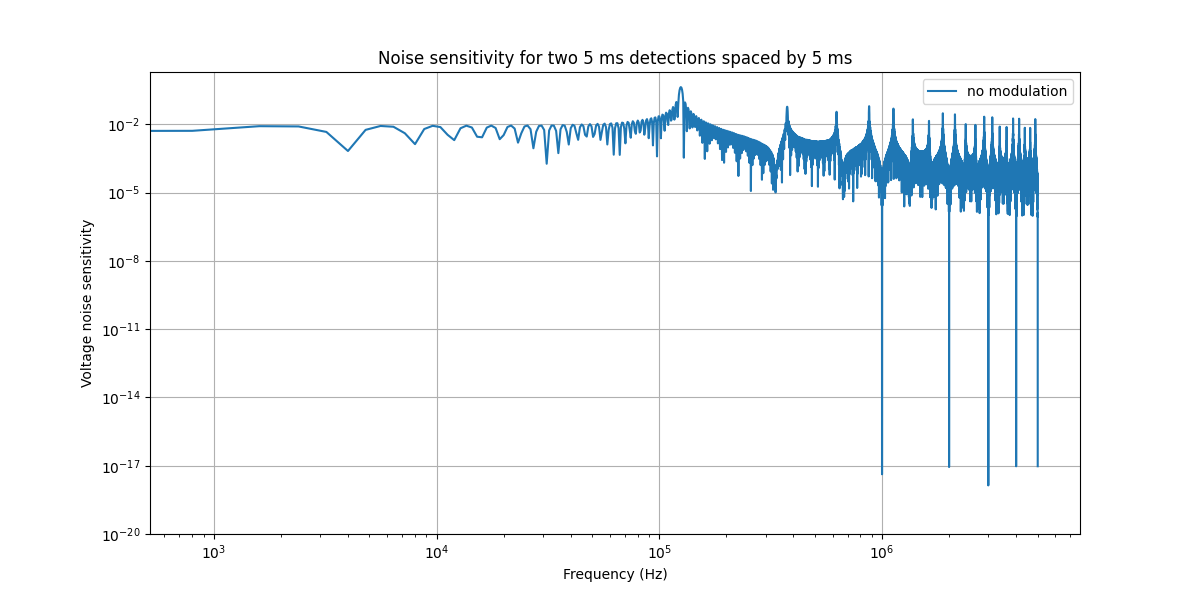

In [226]:
fig, ax = plt.subplots(figsize=(12, 6))
sp = SingleProbe(3e-6, 1e-6, sample_rate=10e6, total_time=1e-3)
freqs, amplitudes = sp.frequency_sensitivity()
print(np.sum(amplitudes**2) * (freqs[1] - freqs[0]))
ax.plot(freqs, amplitudes, label="no modulation")
# sp = SingleProbe(1e-3, 1e-3, frequency=1e6)
# freqs, amplitudes = sp.frequency_sensitivity()
# print(np.sum(amplitudes**2) * (freqs[1] - freqs[0]))
# ax.plot(freqs, amplitudes, label="1 MHz modulation")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Voltage noise sensitivity")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Noise sensitivity for two 5 ms detections spaced by 5 ms")
ax.set_ylim(1e-20, 2)
ax.legend()
ax.grid()
plt.show()

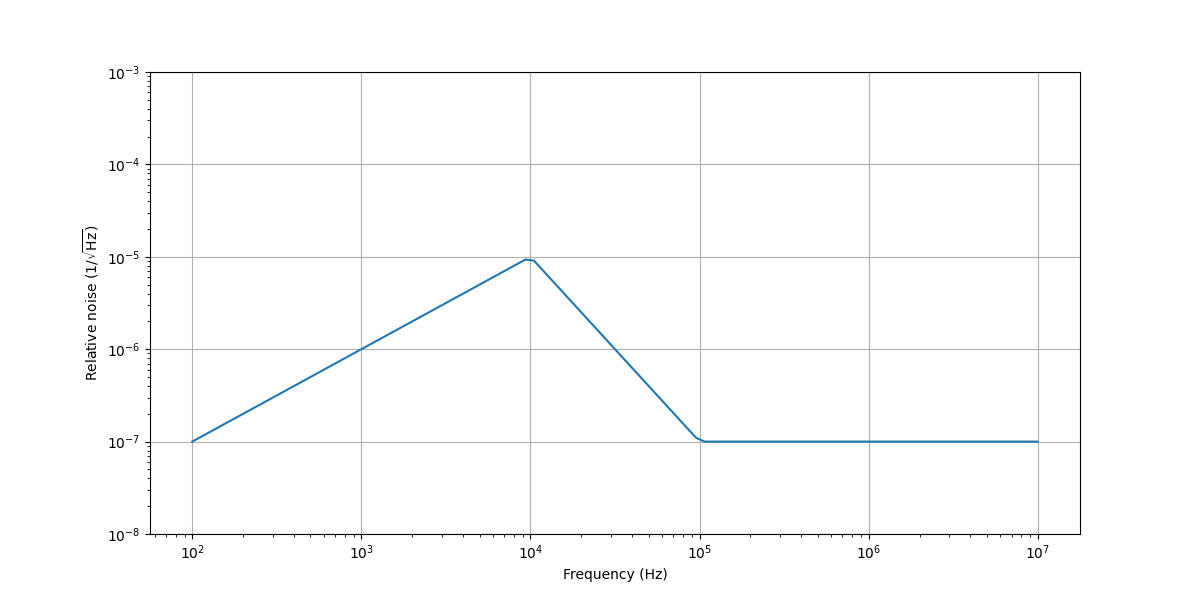

In [240]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.logspace(2, 7, 100)
noises = [noise(x1) for x1 in x]
ax.plot(x, noises)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Relative noise ($1/\\sqrt{\\mathrm{Hz}}$)")
ax.set_ylim(1e-8, 1e-3)
ax.grid()
plt.show()

In [238]:
noises = np.array([noise(freq) for freq in freqs])
print(np.sqrt(np.sum((noises * amplitudes) ** 2 * (freqs[1] - freqs[0]))))

7.687333729901979e-06


In [178]:
t_on = 10e-6 / 1
t_off = 2e-6 / 1
N_mu = 2
t_total = (t_on + t_off) * N_mu
N = 1

sample_rate = 25e6
N_step = int(t_total * sample_rate)
ts = np.arange(0, N_step * N) / sample_rate
phases = np.linspace(0, 2 * np.pi, 20)

In [17]:
def voltage_sine(f, phase=0):
    return np.sin(2 * np.pi * f * ts + phase) * np.sqrt(2)

In [18]:
def data_points(f, phase):
    N_step = int(t_total * sample_rate)
    V = voltage_sine(f, phase).reshape(N, N_step)
    dps = []
    for kk in range(N_mu):
        start = int(kk * (t_on + t_off) * sample_rate)
        end = int((kk * (t_on + t_off) + t_on) * sample_rate)
        dp = np.average(V[:, start:end])
        dps.append(dp)
    return dps

In [19]:
stds = []
fs = np.logspace(0, 8, 1000)
for f in fs:
    std_f = []
    for phase in phases:
        std_f.append(np.std(data_points(f, phase)))
    stds.append(np.average(std_f))
stds = np.array(stds)

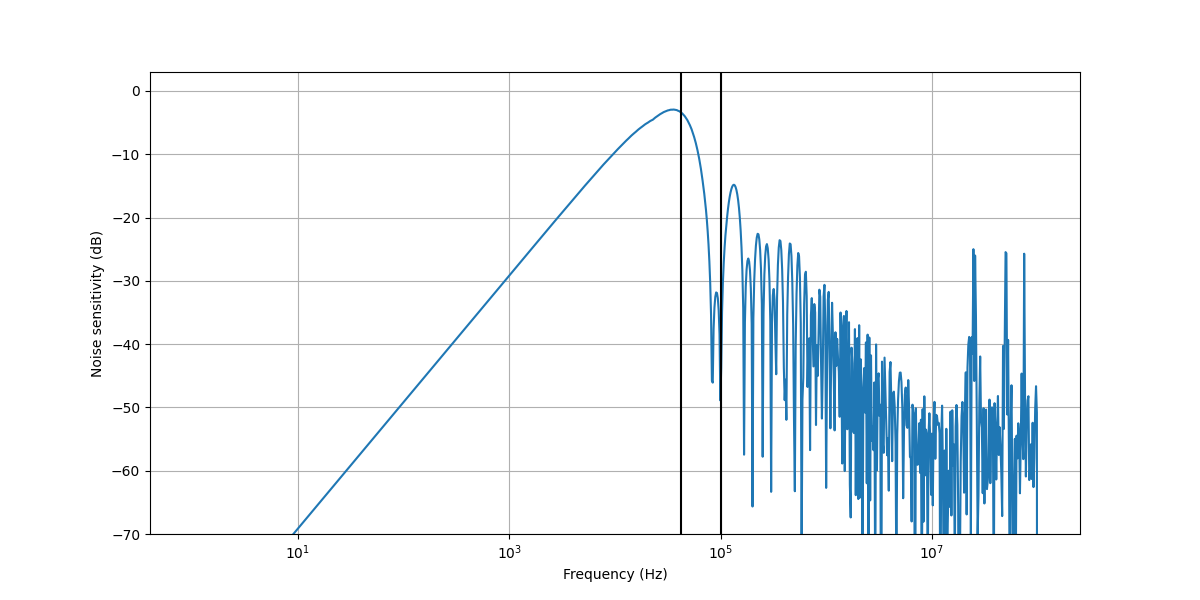

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(fs, np.log10(stds ** 2) * 10)
ax.set_xscale("log")
ylim_low, ylim_high = ax.get_ylim()
ax.vlines([1 / t_on, 1 / t_total], ylim_low, ylim_high, color="k")
ax.set_ylim(np.max([ylim_low, -70]), 3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Noise sensitivity (dB)")
ax.grid()
plt.show()